# Sample generator

In [1]:
import os
import io
import sys
import zipfile

import IPython.display as ipd

from numpy import *
from matplotlib.pyplot import *
from matplotlib import rcParams
from scipy.io import wavfile
from scipy import signal
from collections import namedtuple
from numba import jit

rcParams['figure.figsize'] = 10, 4
sys.path.append("..")

from samplegen import *
%load_ext autoreload
%autoreload 2

## Find loop points

In [6]:
def zcd(x, rising=True):
    # Find all indexes just before a zero-crossing
    if rising:
        return where(0 < diff(sign(x)))[0]
    else:
        return where(0 > diff(sign(x)))[0]

def player(x, fs):
    ipd.display(ipd.Audio(data=x, rate=fs))
    
def player_looped(x, fs, loop_start, loop_stop, samples=300):
    y = hstack([
        x[0:loop_stop],
        x[loop_start:loop_stop],
        x[loop_start:loop_stop],
        x[loop_start:],
    ])
    ipd.display(ipd.Audio(data=y, rate=fs))
    fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=[10, 12])
    t = arange(len(x))/len(x)
    
    ax1.plot(t, x)
    ax1.axvspan((loop_start-samples/2)/len(x), (loop_start+samples/2)/len(x), color="k")
    ax1.axvspan((loop_stop-samples/2)/len(x), (loop_stop+samples/2)/len(x), color="k")
    ax1.set_ylabel("Sample and loop points")
    
    n = arange(samples, dtype=int) - samples//2
    y = (x[n+loop_start] - x[n+loop_stop]) / (2*max(x))
    ax2.plot(y)
    ax2.set_ylim(-1, 1)
    ax2.set_ylabel("Loop start - Loop stop")
    
    n = arange(300, dtype=int) - 300//2
    ax3.plot(n, x[n+loop_start])
    ax3.plot(n, x[n+loop_stop])
    ax3.set_ylabel("Overlayed start and stop")

#def pearson_correlation_coefficient(x, y):
    
    
def loop_point_correlation(x, l1, l2, overlap):
    """Evaluate the correlation between the start and the stop point."""
    try:
        assert(l1-overlap//2 > 0)
        assert(l2-overlap//2 > 0)
        assert(l1+overlap//2 < len(x))
        assert(l2+overlap//2 < len(x))
    except AssertionError:
        print("Index out of range: {:d} or {:d}".format(l1, l2))
        print("Corr", l1, l2, overlap)
        raise IndexError
    
    x1 = x[l1-overlap//2 : l1+overlap//2]
    x2 = x[l2-overlap//2 : l2+overlap//2]
    
    if len(x1) != len(x2):
        raise IndexError("{:d} != {:d}".format(len(x1), len(x2)))
    else:
        
        # Pearson correlation coefficient
        # Note: x and y are scaled to prevent overflow!
        n = len(x1)
        x = array(x1)/n
        y = array(x2)/n
        
        N1 = n*sum(x*y)
        N2 = sum(x) * sum(y)
        D1 = n*sum(x**2) - sum(x)**2
        D2 = n*sum(y**2) - sum(y)**2
        try:
            assert(D1*D2 >= 0)
            r = (N1 - N2)/sqrt(D1 * D2)
            return r
        except AssertionError as e:
            print(N1, N2, D1, D2)
            raise e

def find_best_stop(x, l1, overlap):
    """Find the best stop-point for a given start point."""
    L = len(x)
    z = zcd(x, rising=True)
    R = zeros(L)
    
    # Loop through all other zero crossings and compute a correlation for each
    for l2 in z[(l1 < z) & (z < L-overlap//2)]:
        R[l2] = loop_point_correlation(x, l1, l2, overlap)

    l2 = argmax(abs(R))
    return l2

def find_loop_points(x, start, overlap):
    L = len(x)
    
    # Find zero-crossings
    z = zcd(x, rising=True)
    
    # Extract first part of correlation
    l1 = z[argmax(z>start)]
    l2 = find_best_stop(x, l1, overlap)
    
    return l1, l2

def find_loop_points_with_overlap(x, overlap):
    """Bisect the start position to find the optimal start
    and stop position for a given correlation overlap.
    """
    
    L = len(x)
    zero_crossings = zcd(x, rising=True)
    nearest_zero_crossing = lambda n: zero_crossings[argmax(zero_crossings > n)]
    frac = lambda x: nearest_zero_crossing(x*L)

    p1 = nearest_zero_crossing(overlap)
    p2 = nearest_zero_crossing(L - overlap)
    
    # Use bisection to obtain the best start point
    # p = start point
    # s = stop point
    
    score1 = 0
    score2 = 0
    pbest = p1
    sbest = 0
    p1prev = None
    p2prev = None
    for n in range(200):
        #print("Start:", p1, p2, L, overlap)
        
        # Check if too close to boundaries
        if p1 - overlap//2 < 0:
            break
        elif p2 + overlap//2 > L-1:
            break
        
        s1 = find_best_stop(x, p1, overlap)
        s2 = find_best_stop(x, p2, overlap)
        score1 = loop_point_correlation(x, p1, s1, overlap)
        score2 = loop_point_correlation(x, p2, s2, overlap)
        pcenter = nearest_zero_crossing((p1+p2)/2)
        
        if score1 < score2:
            pbest = p2
            sbest = s2
            p1 = pcenter
        else:
            pbest = p1
            sbest = s2
            p2 = pcenter

        # Check for convergence
        if p1 == p1prev and p2 == p2prev:
            break
        else:
            p1prev = p1
            p2prev = p2

    return pbest, sbest

def find_loop_points_auto(x):
    """Automatically find the optimal loop points for a given audio vector."""
    results = []
    Rmax = -inf
    nmax = None
    overlaps = [int(X*len(x)) for X in [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3]]
    percent = lambda X: 100 * X/len(x)
    
    l1 = 0
    l2 = 0
    for n, overlap in enumerate(overlaps):
        try:
            l1, l2 = find_loop_points_with_overlap(x, overlap)
            R = loop_point_correlation(x, l1, l2, overlap)
        except IndexError:
            continue
        
        results.append([l1, l2, R])
        
        if Rmax < R:
            Rmax = R
            nmax = n
        print(percent(overlap), R)

    overlap = overlaps[nmax]
    l1, l2 = results[nmax][0], results[nmax][1]
    print("Optimal overlap: {:.1f} %".format(percent(overlap)))
    player_looped(x, 44100, l1, l2, overlap)
    return l1, l2
   
def bitwig_loop_and_save(input_file, output_file, note_root):
    fs, x = wavfile.read(input_file)
    
    l1, l2 = find_loop_points_auto(x)
    print("Loop points: {:d}, {:d}".format(l1, l2))
    
    bitwig.write_single(
        output_file,
        sample_t(
            filename = input_file,
            note_root = note_root,
            note_max = 127,
            note_min = 0,
            loop_start = l1,
            loop_stop = l2,
        ),
    )


0.5 -0.3581866897001667
1.0 -0.3532048394716775
2.0 -0.132867595123133
5.0 0.9966662546725206
10.0 -0.23129349877546596
20.0 0.09733275685962524
30.0 0.09337077841278879
Optimal overlap: 5.0 %


Loop points: 138767, 245409
13.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


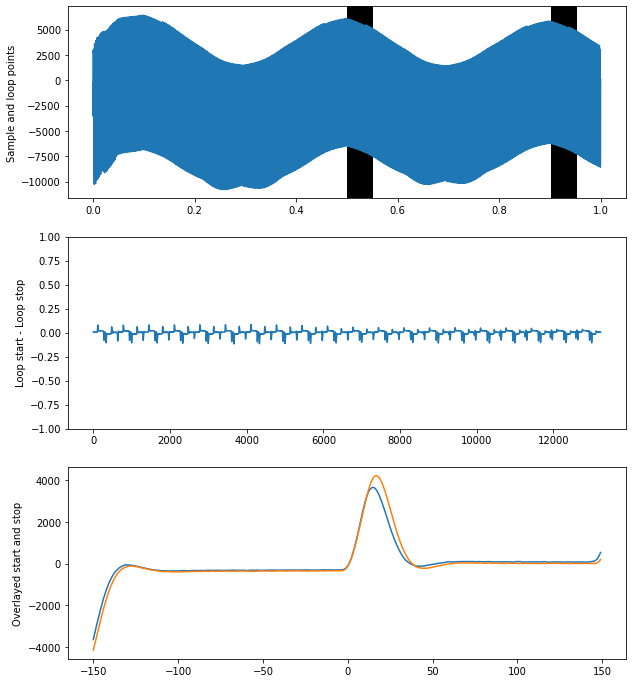

In [8]:
%%timeit -n1 -r1
bitwig_loop_and_save(
    input_file = "/home/soren/Dropbox/instruments/samples/vintage_synth_samples/roland_jupiter-8_vol1/Vintage Synth Samples - ROLAND JUPITER-8 VOL. 1 - 21 ROLAND JUPITER-8.wav",
    output_file = "vss_jupyter_21.multisample",
    note_root = 36,   
)

In [ ]:
bitwig_loop_and_save(
    input_file = "/home/soren/vcs/sbnsampler/app/sound/zebra_cello1_c4.wav",
    output_file = "zebra_cello1.multisample",
    note_root = 60,
)

In [ ]:
%%timeit -r1 -n1

bitwig_loop_and_save(
    input_file = "/home/soren/vcs/sbnsampler/app/sound/mellotron_m300b_e3.wav",
    output_file = "mellotron_m300b_e3.multisample",
    note_root = 52,
)